
# Temporal Venue Classification
Train temporal text classifiers to predict future paper venues. This notebook:
- Builds a streaming dataset from the DBLP dump with a temporal split.
- Restricts labels to the most frequent venues to reduce imbalance/noise.
- Fits/evaluates baseline classifiers (majority, linear models on TF-IDF).
- Surfaces per-class performance and informative terms.


In [65]:

from pathlib import Path
import json
from collections import Counter, defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
import matplotlib.pyplot as plt


In [ ]:
DATA_DIR = Path("data")
FILES = sorted(DATA_DIR.glob("dblp-ref-*.json"))

TOP_VENUE_N = 6
TRAIN_END = 2013 
VAL_END = 2015
SAMPLE_LIMIT = None

TEXT_COLS = ["title", "abstract"]
MAX_FEATURES = 10000
NGRAM_RANGE = (1, 2)


In [67]:

def iter_records(files):
    for fp in files:
        with fp.open() as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    yield json.loads(line)
                except json.JSONDecodeError:
                    continue

def clean_text(value):
    if value is None:
        return None
    text = str(value).strip()
    return text if text else None

def clean_year(value):
    if value is None:
        return None
    try:
        year = int(value)
    except (ValueError, TypeError):
        return None
    return year if 1800 <= year <= 2030 else None


## Build venue frequency table (streaming)

In [68]:

venue_counts = Counter()
for rec in iter_records(FILES):
    venue = clean_text(rec.get("venue"))
    if venue:
        venue_counts[venue] += 1

venue_df = (
    pd.DataFrame({"venue": list(venue_counts.keys()), "papers": list(venue_counts.values())})
    .sort_values("papers", ascending=False)
    .reset_index(drop=True)
)

venue_df.head(10), venue_df.shape[0]


(                                               venue  papers
 0                  Lecture Notes in Computer Science   32137
 1  international conference on acoustics, speech,...   26621
 2  international conference on robotics and autom...   19943
 3       international conference on image processing   18336
 4         international conference on communications   17679
 5    international symposium on circuits and systems   16945
 6                   global communications conference   15850
 7  international geoscience and remote sensing sy...   15390
 8                     intelligent robots and systems   14698
 9  conference of the international speech communi...   13510,
 5078)

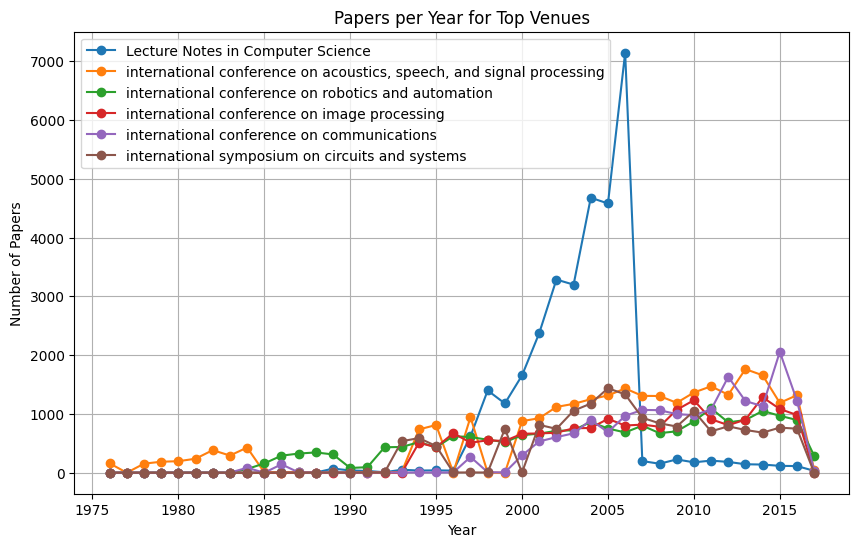

In [69]:
# Line plot: papers per year for chosen venues.
import matplotlib.pyplot as plt

exclude_venue = "Lecture Notes in Computer Science"
top_venues = venue_df.head(TOP_VENUE_N)["venue"].tolist()
year_venue_counts = defaultdict(lambda: Counter())
for rec in iter_records(FILES):
    venue = clean_text(rec.get("venue"))
    year = clean_year(rec.get("year"))
    if venue in top_venues and year is not None:
        year_venue_counts[year][venue] += 1
year_venue_df = pd.DataFrame(year_venue_counts).fillna(0).astype(int).T.sort_index()
year_venue_df = year_venue_df[top_venues]
year_venue_df.plot(kind="line", figsize=(10, 6), marker="o")
plt.title("Papers per Year for Top Venues")
plt.xlabel("Year")
plt.xticks(range(year_venue_df.index.min() - 1, year_venue_df.index.max() + 1, 5))
plt.ylabel("Number of Papers")
plt.grid(True)
plt.show()

## Filter to top venues and create temporal splits

In [70]:
target_venues = [v for v in top_venues if v != exclude_venue][:5]
target_venues = set(target_venues)

rows = []
for rec in iter_records(FILES):
    venue = clean_text(rec.get("venue"))
    if venue not in target_venues:
        continue

    year = clean_year(rec.get("year"))
    if year is None:
        continue  # skip papers with unknown year

    title = clean_text(rec.get("title")) or ""
    abstract = clean_text(rec.get("abstract")) or ""
    text = f"{title} {abstract}".strip()

    n_cit_raw = rec.get("n_citation")
    try:
        n_cit = int(n_cit_raw)
    except (ValueError, TypeError):
        n_cit = None

    if year <= TRAIN_END:
        split = "train"
    elif year <= VAL_END:
        split = "val"
    else:
        split = "test"

    rows.append({
        "title": title,
        "abstract": abstract,
        "text": text,
        "venue": venue,
        "year": year,
        "n_citation": n_cit,
        "split": split,
    })

    if SAMPLE_LIMIT is not None and len(rows) >= SAMPLE_LIMIT:
        break

filtered_df = pd.DataFrame(rows)
filtered_df.head()


,title,abstract,text,venue,year,n_citation,split
0,Antenna Array Receiver Using Channel Estimatio...,,Antenna Array Receiver Using Channel Estimatio...,international conference on communications,2000,0,train
1,An Integrated Robotic Hand/Simulator System fo...,,An Integrated Robotic Hand/Simulator System fo...,international conference on robotics and autom...,2001,0,train
2,Protocols for Real Time Voice Communications o...,,Protocols for Real Time Voice Communications o...,international conference on communications,1986,50,train
3,An Efficient Method to Find Invalid Loops in a...,,An Efficient Method to Find Invalid Loops in a...,international conference on communications,1986,0,train
4,Progress Toward Mobility in Microfabricated Mi...,Research on mobile millirobots has been ongoin...,Progress Toward Mobility in Microfabricated Mi...,international conference on robotics and autom...,2013,1,train


In [71]:

# Split sizes and class balance
split_counts = filtered_df["split"].value_counts().to_frame("papers")
split_counts


,papers
split,
train,82122
val,11867
test,5535


## Prepare text and labels

In [72]:

# Combine text fields
filtered_df["text"] = filtered_df[TEXT_COLS].agg(" ".join, axis=1).str.strip()

train_df = filtered_df[filtered_df["split"] == "train"].reset_index(drop=True)
val_df = filtered_df[filtered_df["split"] == "val"].reset_index(drop=True)
test_df = filtered_df[filtered_df["split"] == "test"].reset_index(drop=True)

X_train = train_df["text"]
y_train = train_df["venue"]
X_val = val_df["text"]
y_val = val_df["venue"]
X_test = test_df["text"]
y_test = test_df["venue"]

y_train.value_counts().head()

# create a table which has venue, train count, val count, test count and total values
venue_split_counts = filtered_df.pivot_table(index="venue", columns="split", aggfunc="size", fill_value=0)
venue_split_counts["total"] = venue_split_counts.sum(axis=1)
venue_split_counts.head()


split,test,train,val,total
venue,,,,
"international conference on acoustics, speech, and signal processing",1367,22409,2845,26621
international conference on communications,1254,13238,3187,17679
international conference on image processing,981,14988,2367,18336
international conference on robotics and automation,1184,16740,2019,19943
international symposium on circuits and systems,749,14747,1449,16945


## Baseline: majority class

In [73]:

majority_class = y_train.value_counts().idxmax()
majority_pred_val = [majority_class] * len(y_val)
majority_pred_test = [majority_class] * len(y_test)

maj_val_acc = accuracy_score(y_val, majority_pred_val) if len(y_val) else None
maj_test_acc = accuracy_score(y_test, majority_pred_test) if len(y_test) else None

maj_val_acc, maj_test_acc, majority_class


(0.23974045672874358,
 0.24697380307136405,
 'international conference on acoustics, speech, and signal processing')

## Model: Logistic Regression on TF-IDF (word n-grams)

In [74]:
logreg_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=MAX_FEATURES,
        ngram_range=NGRAM_RANGE,
        lowercase=True,
        stop_words="english",
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=200,
        multi_class="auto",
        class_weight="balanced"
    )),
])

logreg_pipe


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [75]:

logreg_pipe.fit(X_train, y_train)

val_pred = logreg_pipe.predict(X_val)
test_pred = logreg_pipe.predict(X_test)

val_acc = accuracy_score(y_val, val_pred)
val_f1 = f1_score(y_val, val_pred, average="macro")

test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred, average="macro")

val_acc, val_f1, test_acc, test_f1


/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(0.8097244459425297,
 0.8058633531385715,
 0.8160794941282746,
 0.8153808189809084)

In [76]:

print("Validation report:", classification_report(y_val, val_pred, digits=3))
print("Test report:", classification_report(y_test, test_pred, digits=3))


Validation report:                                                                       precision    recall  f1-score   support

international conference on acoustics, speech, and signal processing      0.777     0.691     0.732      2845
                          international conference on communications      0.871     0.894     0.882      3187
                        international conference on image processing      0.728     0.798     0.761      2367
                 international conference on robotics and automation      0.913     0.885     0.899      2019
                     international symposium on circuits and systems      0.740     0.772     0.756      1449

                                                            accuracy                          0.810     11867
                                                           macro avg      0.806     0.808     0.806     11867
                                                        weighted avg      0.811     0.810     0.809

## Interpretability: top terms per class

In [77]:
import numpy as np

vectorizer = logreg_pipe.named_steps["tfidf"]
clf = logreg_pipe.named_steps["clf"]

feature_names = np.array(vectorizer.get_feature_names_out())
classes = clf.classes_

def top_terms_for_class(class_idx, k=15):
    coefs = clf.coef_[class_idx]
    top_idx = np.argsort(coefs)[-k:][::-1]  # largest weights
    return feature_names[top_idx], coefs[top_idx]

# Print top terms per venue
for cls_idx, venue in enumerate(classes):
    print(f"\n=== Top terms for venue: {venue} ===")
    terms, weights = top_terms_for_class(cls_idx)
    for t, w in zip(terms, weights):
        print(f"  {t:25s}  weight={w:.4f}")



=== Top terms for venue: international conference on acoustics, speech, and signal processing ===
  speech                     weight=6.5138
  acoustic                   weight=4.2173
  speaker                    weight=3.9010
  signal processing          weight=3.8647
  audio                      weight=3.7465
  spoken                     weight=3.6223
  dsp                        weight=3.3658
  word                       weight=2.6520
  phone                      weight=2.5410
  language                   weight=2.4529
  sound                      weight=2.4415
  loudspeaker                weight=2.4386
  music                      weight=2.3228
  microphone                 weight=2.2343
  eeg                        weight=2.1786

=== Top terms for venue: international conference on communications ===
  traffic                    weight=4.5936
  networks                   weight=3.5635
  numerical results          weight=3.5517
  network                    weight=3.5184
  radio    


## Model tuning: word vs char n-grams
Sweep simple hyperparameters (C) for word and character TF-IDF + logistic regression using the validation split, then evaluate the best model on the test set.


In [78]:
# Tuning knobs
WORD_C_VALUES = [0.5, 1.0]
CHAR_C_VALUES = [0.5, 1.0]
CHAR_NGRAM_RANGE = (3, 5)
CHAR_MAX_FEATURES = 50000
CHAR_MIN_DF = 2


In [79]:
def run_sweep(configs):
    records = []
    best_models = {}
    for cfg in configs:
        name = cfg["name"]
        vec_kwargs = cfg["vectorizer_kwargs"]
        c_values = cfg["C_values"]
        best_val_f1 = -1.0
        best_model = None
        for c in c_values:
            pipe = Pipeline([
                ("tfidf", TfidfVectorizer(**vec_kwargs)),
                ("clf", LogisticRegression(max_iter=400, multi_class="auto", class_weight="balanced", C=c)),
            ])
            pipe.fit(X_train, y_train)
            val_pred = pipe.predict(X_val)
            val_acc = accuracy_score(y_val, val_pred)
            val_f1 = f1_score(y_val, val_pred, average="macro")
            records.append({"config": name, "C": c, "val_acc": val_acc, "val_macro_f1": val_f1})
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model = pipe
        best_models[name] = {"model": best_model, "val_macro_f1": best_val_f1}
    results_df = pd.DataFrame(records).sort_values(["config", "val_macro_f1"], ascending=[True, False])
    return results_df, best_models

configs = [
    {
        "name": "word",
        "vectorizer_kwargs": {
            "max_features": MAX_FEATURES,
            "ngram_range": NGRAM_RANGE,
            "analyzer": "word",
            "min_df": 2,
        },
        "C_values": WORD_C_VALUES,
    },
    {
        "name": "char",
        "vectorizer_kwargs": {
            "max_features": CHAR_MAX_FEATURES,
            "ngram_range": CHAR_NGRAM_RANGE,
            "analyzer": "char",
            "min_df": CHAR_MIN_DF,
        },
        "C_values": CHAR_C_VALUES,
    },
]

sweep_df, best_models = run_sweep(configs)
sweep_df


/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default va

,config,C,val_acc,val_macro_f1
3,char,1.0,0.810651,0.807145
2,char,0.5,0.808966,0.805091
0,word,0.5,0.805595,0.801603
1,word,1.0,0.802562,0.798693


In [80]:

# Pick the single best model by validation macro-F1 and evaluate on validation + test
best_name = max(best_models.items(), key=lambda kv: kv[1]["val_macro_f1"])[0]
best_model = best_models[best_name]["model"]

val_pred_best = best_model.predict(X_val)
test_pred_best = best_model.predict(X_test)

best_val_acc = accuracy_score(y_val, val_pred_best)
best_val_f1 = f1_score(y_val, val_pred_best, average="macro")

best_test_acc = accuracy_score(y_test, test_pred_best)
best_test_f1 = f1_score(y_test, test_pred_best, average="macro")

best_name, best_val_acc, best_val_f1, best_test_acc, best_test_f1


('char',
 0.8106513861970169,
 0.807144872959378,
 0.8191508581752485,
 0.818277633026433)

In [81]:

print(f"Validation report ({best_name} model):", classification_report(y_val, val_pred_best, digits=3))
print(f"Test report ({best_name} model):", classification_report(y_test, test_pred_best, digits=3))


Validation report (char model):                                                                       precision    recall  f1-score   support

international conference on acoustics, speech, and signal processing      0.793     0.681     0.733      2845
                          international conference on communications      0.867     0.893     0.880      3187
                        international conference on image processing      0.731     0.805     0.766      2367
                 international conference on robotics and automation      0.924     0.876     0.899      2019
                     international symposium on circuits and systems      0.719     0.802     0.758      1449

                                                            accuracy                          0.811     11867
                                                           macro avg      0.807     0.811     0.807     11867
                                                        weighted avg      0.814     0.

In [82]:
import numpy as np

vectorizer = best_model.named_steps["tfidf"]
clf = best_model.named_steps["clf"]

feature_names = np.array(vectorizer.get_feature_names_out())

def top_terms_for_class(class_idx, k=15):
    coefs = clf.coef_[class_idx]
    top_idx = np.argsort(coefs)[-k:][::-1]
    return feature_names[top_idx], coefs[top_idx]

for cls_idx, venue in enumerate(clf.classes_):
    print(f"\n=== Top terms for venue: {venue} ===")
    terms, weights = top_terms_for_class(cls_idx)
    for t, w in zip(terms, weights):
        print(f"  {t:25s}  weight={w:.4f}")



=== Top terms for venue: international conference on acoustics, speech, and signal processing ===
  peech                      weight=2.3775
  eech                       weight=2.3525
  speec                      weight=2.3396
  peec                       weight=2.3348
  eec                        weight=2.2936
  dsp                        weight=2.2761
  eech                       weight=2.0667
  ech                        weight=2.0498
  nal p                      weight=1.9568
   word                      weight=1.8105
  voc                        weight=1.6881
  udio                       weight=1.6722
  phon                       weight=1.6686
   spe                       weight=1.6386
   dsp                       weight=1.6287

=== Top terms for venue: international conference on communications ===
  net                        weight=2.0611
  ecodi                      weight=2.0573
   code                      weight=1.9821
   ip                        weight=1.9165
  optic    


## Fast sweep (bounded runtime)
Use a capped sample for quick iteration; runs word TF-IDF only and selects the best C by validation macro-F1.


In [83]:

# Fast-mode parameters
FAST_SAMPLE_LIMIT = None
FAST_RANDOM_STATE = 42

In [84]:

# Build a capped dataframe for fast experiments (per-split sampling)
if FAST_SAMPLE_LIMIT is not None and len(filtered_df) > FAST_SAMPLE_LIMIT:
    frac = FAST_SAMPLE_LIMIT / len(filtered_df)
    def sample_split(df):
        n = max(1, int(len(df) * frac))
        return df.sample(n=n, random_state=FAST_RANDOM_STATE)
    filtered_fast = pd.concat([sample_split(g) for _, g in filtered_df.groupby('split')])
else:
    filtered_fast = filtered_df.copy()

filtered_fast["text"] = filtered_fast[TEXT_COLS].agg(" ".join, axis=1).str.strip()

train_fast = filtered_fast[filtered_fast["split"] == "train"].reset_index(drop=True)
val_fast = filtered_fast[filtered_fast["split"] == "val"].reset_index(drop=True)
test_fast = filtered_fast[filtered_fast["split"] == "test"].reset_index(drop=True)

X_train_fast, y_train_fast = train_fast["text"], train_fast["venue"]
X_val_fast, y_val_fast = val_fast["text"], val_fast["venue"]
X_test_fast, y_test_fast = test_fast["text"], test_fast["venue"]

len(filtered_fast), train_fast.shape[0], val_fast.shape[0], test_fast.shape[0]


(99524, 82122, 11867, 5535)

In [85]:

# Word-only fast sweep
auto_configs = [
    {
        "name": "word_fast",
        "vectorizer_kwargs": {
            "max_features": MAX_FEATURES,
            "ngram_range": NGRAM_RANGE,
            "analyzer": "word",
            "min_df": 2,
        },
        "C_values": WORD_C_VALUES,
    },
]

fast_records = []
best_fast = None

for cfg in auto_configs:
    for c in cfg["C_values"]:
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(**cfg["vectorizer_kwargs"])),
            ("clf", LogisticRegression(max_iter=400, multi_class="auto", class_weight="balanced", C=c)),
        ])
        pipe.fit(X_train_fast, y_train_fast)
        val_pred = pipe.predict(X_val_fast)
        val_acc = accuracy_score(y_val_fast, val_pred)
        val_f1 = f1_score(y_val_fast, val_pred, average="macro")
        fast_records.append({"config": cfg["name"], "C": c, "val_acc": val_acc, "val_macro_f1": val_f1})
        if best_fast is None or val_f1 > best_fast["val_macro_f1"]:
            best_fast = {"model": pipe, "config": cfg["name"], "C": c, "val_macro_f1": val_f1}

fast_results_df = pd.DataFrame(fast_records).sort_values(["val_macro_f1"], ascending=False)
fast_results_df


/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/aisulutulyeujan/Desktop/UH/Fall 2025/COSC 3337/final project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,config,C,val_acc,val_macro_f1
0,word_fast,0.5,0.805595,0.801603
1,word_fast,1.0,0.802562,0.798693


In [86]:

# Evaluate the best fast model on val/test
best_model_fast = best_fast["model"]
val_pred_best = best_model_fast.predict(X_val_fast)
test_pred_best = best_model_fast.predict(X_test_fast)

val_acc = accuracy_score(y_val_fast, val_pred_best)
val_f1 = f1_score(y_val_fast, val_pred_best, average="macro")

test_acc = accuracy_score(y_test_fast, test_pred_best)
test_f1 = f1_score(y_test_fast, test_pred_best, average="macro")

best_fast, (val_acc, val_f1), (test_acc, test_f1)


({'model': Pipeline(steps=[('tfidf',
                   TfidfVectorizer(max_features=10000, min_df=2,
                                   ngram_range=(1, 2))),
                  ('clf',
                   LogisticRegression(C=0.5, class_weight='balanced',
                                      max_iter=400, multi_class='auto'))]),
  'config': 'word_fast',
  'C': 0.5,
  'val_macro_f1': 0.8016030745163771},
 (0.8055953484452684, 0.8016030745163771),
 (0.8186088527551942, 0.8180709828623289))

In [87]:

print("Validation report (fast best):", classification_report(y_val_fast, val_pred_best, digits=3))
print("Test report (fast best):", classification_report(y_test_fast, test_pred_best, digits=3))


Validation report (fast best):                                                                       precision    recall  f1-score   support

international conference on acoustics, speech, and signal processing      0.780     0.685     0.729      2845
                          international conference on communications      0.874     0.883     0.879      3187
                        international conference on image processing      0.724     0.804     0.762      2367
                 international conference on robotics and automation      0.917     0.868     0.892      2019
                     international symposium on circuits and systems      0.709     0.787     0.746      1449

                                                            accuracy                          0.806     11867
                                                           macro avg      0.801     0.806     0.802     11867
                                                        weighted avg      0.809     0.8